# Diabetes

| **Modelo**                          | **Precisión (Accuracy)** | **Precisión (Clase 1)** | **Sensibilidad (Recall, Clase 1)** | **F1-Score (Clase 1)** |
|-------------------------------------|--------------------------|--------------------------|-------------------------------------|-------------------------|
| **Modelo con todas las variables**  | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con imputación básica**    | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con `Glucose`, `Age`, `BMI`** | 0.75                    | 0.66                    | 0.64                               | 0.65                   |
| **Modelo con `class_weight='balanced'` (Glucose, Age, BMI)** | 0.71 | 0.58 | 0.69 | 0.63 |
| **Modelo con `class_weight='balanced'` (todas las variables)** | 0.69 | 0.55 | 0.69 | 0.61 |
| **Modelo usando SMOTE**             | 0.69                    | 0.56                    | 0.71                               | 0.62                   |
| **Random Forest sin SMOTE**         | 0.77                    | 0.68                    | 0.69                               | 0.68                   |
| **Random Forest con SMOTE**         | 0.75                    | 0.62                    | 0.76                               | 0.68                   |
| **`Random Forest con SMOTE y Características Importantes`** | `0.77` | `0.65` | `0.80` | `0.72` |
| **Regresión Logística con SMOTE y Características Importantes** | 0.71 | 0.58 | 0.73 | 0.65 |

## Importar librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier


# Configuraciones generales
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## Cargamos los datos

### Descripción inicial del dataset

El dataset de Diabetes contiene información de los pacientes de diabetes, con la siguiente información:
- Tamaño del dataset: 768 filas y 9 columnas.
- Columnas disponibles:
    - `Pregnancies`: Número de embarazos.
    - `Glucose`: Nivel de glucosa.
    - `BloodPressure`: Presión arterial.
    - `SkinThickness`: Grosor del pliegue cutáneo.
    - `Insulin`: Nivel de insulina.
    - `BMI`: Índice de Masa Corporal (IMC).
    - `DiabetesPedigreeFunction`: Función de pedigrí de diabetes (herencia familiar).
    - `Age`: Edad.
    - `Outcome`: Resultado (1 indica diabetes, 0 indica no diabetes).


In [3]:
data = pd.read_csv("../resources/diabetes.csv")
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [4]:
# La variable objetivo es 'Outcome'
# Verificamos la distribución de los valores en la variable 'Outcome'
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

## Estadísticas descriptivas

In [5]:
descriptive_stats = data.describe()
descriptive_stats

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## ---> Modelo inicial con el dataset original

In [7]:
# Separar las características (X) y la etiqueta (y)
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar un modelo de Regresión Logística
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas
print(f"Precisión (Accuracy): {accuracy:.2f}")
print(f"Precisión por clase (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

report = classification_report(y_test, y_pred)

# Imprimir resultados
print(f"Precisión del modelo: {accuracy:.2f}")
print("\nReporte de Clasificación:")
print(report)

Precisión (Accuracy): 0.75
Precisión por clase (Precision): 0.64
Sensibilidad (Recall): 0.67
F1-Score: 0.65
Precisión del modelo: 0.75

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        99
           1       0.64      0.67      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



---

### Análisis del Modelo Predictivo de Regresión Logística

#### Introducción
El modelo creado es una Regresión Logística para predecir si un paciente tiene diabetes (`Outcome`) basado en diferentes características como nivel de glucosa, presión sanguínea, índice de masa corporal, entre otros.

##### Métricas del Modelo

1. **Precisión (Accuracy):** 0.75
   - Esto significa que el modelo predijo correctamente el 75% de los casos en el conjunto de prueba.

2. **Precisión por clase (Precision):**
   - **Clase 0 (Sin diabetes):** 0.81
   - **Clase 1 (Con diabetes):** 0.64
   - La precisión para la clase `1` es menor, lo que indica que el modelo tiene más errores al clasificar a pacientes como diabéticos.

3. **Sensibilidad (Recall):**
   - **Clase 0:** 0.79
   - **Clase 1:** 0.67
   - La sensibilidad mide cuántos casos positivos reales fueron identificados correctamente. Para la clase `1`, el 67% de los pacientes con diabetes fueron correctamente identificados.

4. **F1-Score:**
   - **Clase 0:** 0.80
   - **Clase 1:** 0.65
   - Este es un balance entre precisión y sensibilidad. La clase `1` tiene un F1-Score más bajo, lo que confirma que el modelo es menos efectivo para identificar correctamente casos positivos.

##### Resumen del Reporte de Clasificación

- **Soporte (Support):**  
  - **Clase 0 (Sin diabetes):** 99 casos en el conjunto de prueba.
  - **Clase 1 (Con diabetes):** 55 casos en el conjunto de prueba.  
  Esto indica un cierto desbalance de clases, con más datos de la clase `0`, lo que puede influir en la precisión general del modelo.

- **Macro Average:**  
  - Promedio no ponderado de las métricas de ambas clases:
    - Precisión: 0.73
    - Sensibilidad: 0.73
    - F1-Score: 0.73

- **Weighted Average:**  
  - Promedio ponderado basado en la cantidad de datos por clase:
    - Precisión: 0.75
    - Sensibilidad: 0.75
    - F1-Score: 0.75

#### Análisis
- El modelo tiene un desempeño moderado, con una precisión general del **75%**.
- Sin embargo, el modelo tiene dificultades con la clase `1` (diabetes), donde la precisión y el F1-Score son menores.
- El desbalance de clases (99 casos de `0` frente a 55 de `1`) puede estar afectando el desempeño del modelo, favoreciendo la clase mayoritaria.
- La sensibilidad para la clase `1` es **67%**, lo que significa que un 33% de los pacientes con diabetes no están siendo detectados correctamente.

#### Recomendaciones para Mejorar el Modelo

1. **Balancear el Dataset:**
   - Utilizar técnicas como sobremuestreo (SMOTE) o submuestreo para balancear las clases.
   
2. **Tratamiento de Datos:**
   - Analizar las características, eliminar o tratar valores atípicos y normalizar los datos.
   
3. **Explorar Otros Modelos:**
   - Probar modelos más complejos como Árboles de Decisión, Random Forests o Gradient Boosting.

4. **Optimización del Modelo:**
   - Realizar un ajuste de hiperparámetros para mejorar el desempeño.

5. **Evaluar Métricas Alternativas:**
   - Usar métricas como la curva ROC-AUC para obtener una visión más completa del desempeño del modelo en clases desbalanceadas.

#### Conclusión
El modelo inicial proporciona una base para el análisis predictivo de la diabetes. Sin embargo, hay oportunidades significativas de mejora, especialmente en la predicción de la clase `1`. Implementar las recomendaciones mencionadas puede ayudar a mejorar el desempeño y la utilidad práctica del modelo.



---

## Analizamos el dataset para tratar sus datos.

Estadísticas Descriptivas:
           Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   120.894531      69.105469      20.536458   79.799479   31.992578
std     31.972618      19.355807      15.952218  115.244002    7.884160
min      0.000000       0.000000       0.000000    0.000000    0.000000
25%     99.000000      62.000000       0.000000    0.000000   27.300000
50%    117.000000      72.000000      23.000000   30.500000   32.000000
75%    140.250000      80.000000      32.000000  127.250000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000

Conteo de Valores Cero por Variable:
 Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


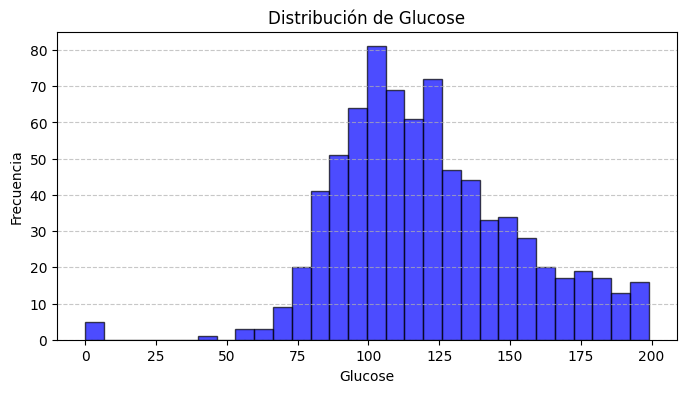

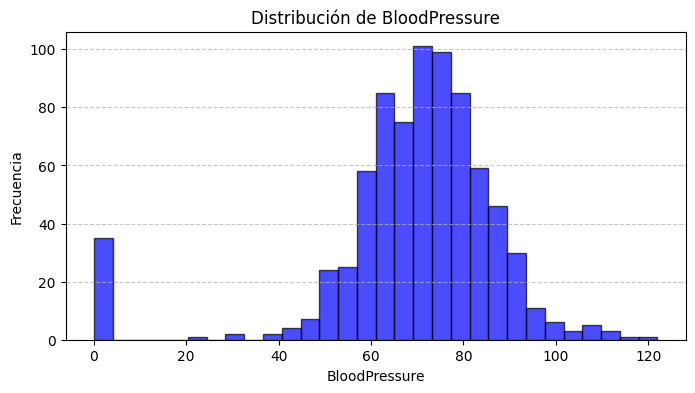

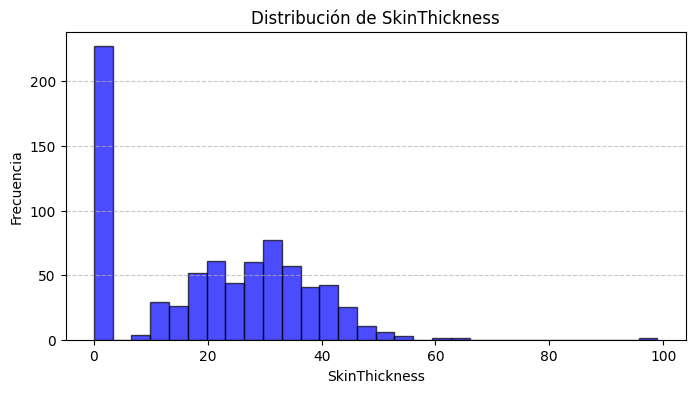

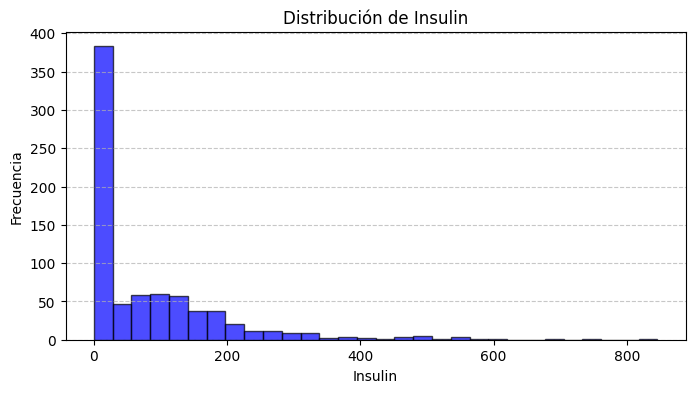

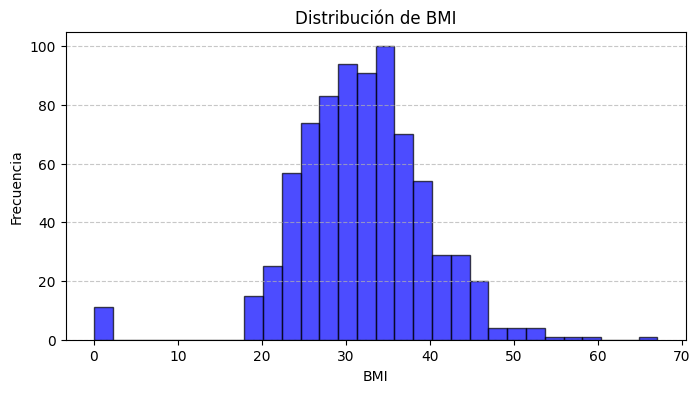

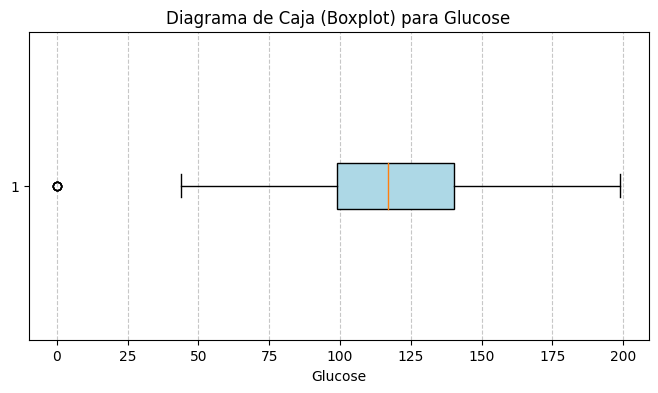

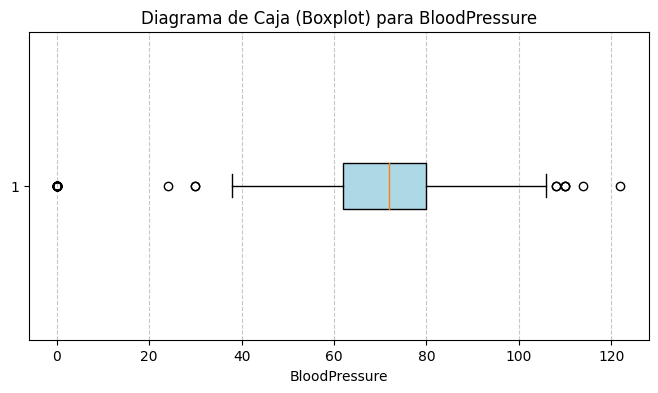

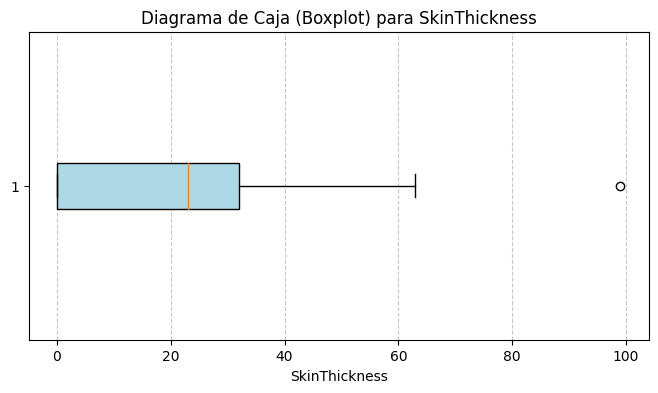

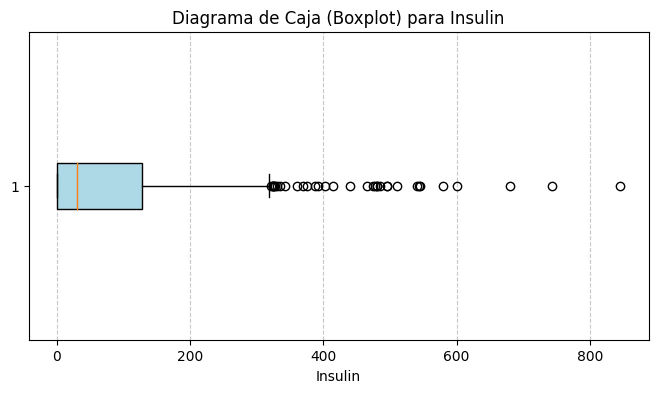

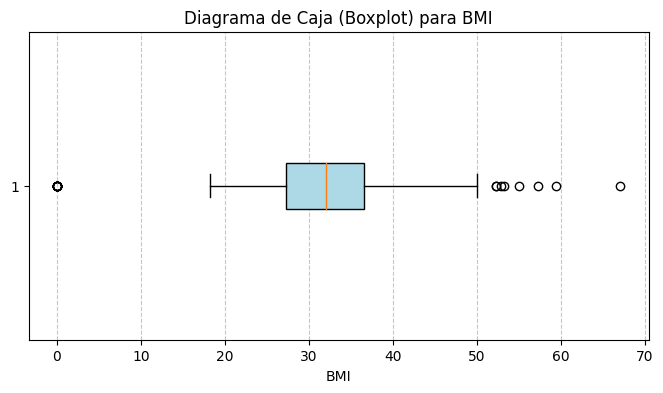

In [8]:
# Listar las columnas que podrían contener valores atípicos o sospechosos
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Calcular estadísticas descriptivas
stats = data[columns_to_check].describe()

# Identificar valores cero en las columnas relevantes
zero_counts = (data[columns_to_check] == 0).sum()

# Mostrar estadísticas descriptivas
print("Estadísticas Descriptivas:\n", stats)

# Mostrar conteo de valores cero
print("\nConteo de Valores Cero por Variable:\n", zero_counts)

# Crear histogramas para visualizar las distribuciones
for column in columns_to_check:
    plt.figure(figsize=(8, 4))
    plt.hist(data[column], bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Crear boxplots para detectar valores atípicos
for column in columns_to_check:
    plt.figure(figsize=(8, 4))
    plt.boxplot(data[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f'Diagrama de Caja (Boxplot) para {column}')
    plt.xlabel(column)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


In [9]:
print("Valores nulos:")
print(data.isnull().sum())  # Valores nulos
print("\nValores igual a cero:")
print((data == 0).sum())  # Valores igual a cero (si aplica)


Valores nulos:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Valores igual a cero:
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


### Analisis resultado
**Variables con valores igual a cero:**

- `Pregnancies`: Es posible que los valores sean correctos porque 0 embarazos es válido.

- `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`: Los valores cero no tienen sentido médico y deben tratarse.
- `DiabetesPedigreeFunction` y `Age`: No presentan valores iguales a cero, no necesitan tratamiento.
- `Outcome`: Aquí, los ceros representan la clase 0, que es válida.

### Analizamos las columnas a tratar: Glucose, BloodPressure, SkinThickness, Insulin, BMI, Age, DiabetesPedigreeFunction.

Coeficiente de Asimetría (Skewness):
 Glucose          0.173414
BloodPressure   -1.840005
SkinThickness    0.109159
Insulin          2.267810
BMI             -0.428143
dtype: float64


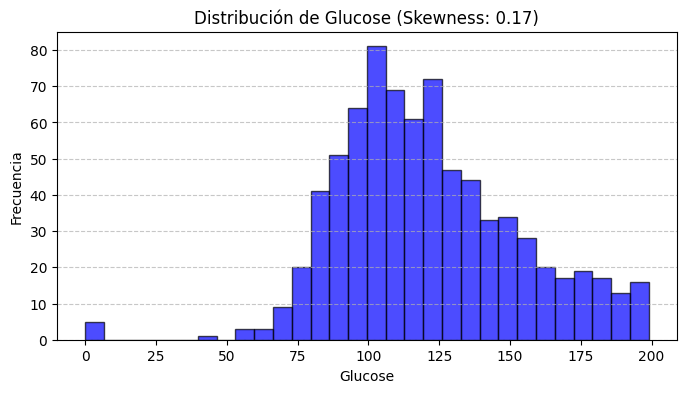

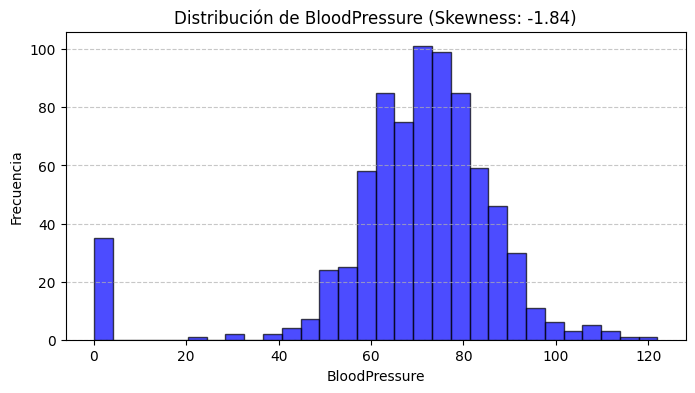

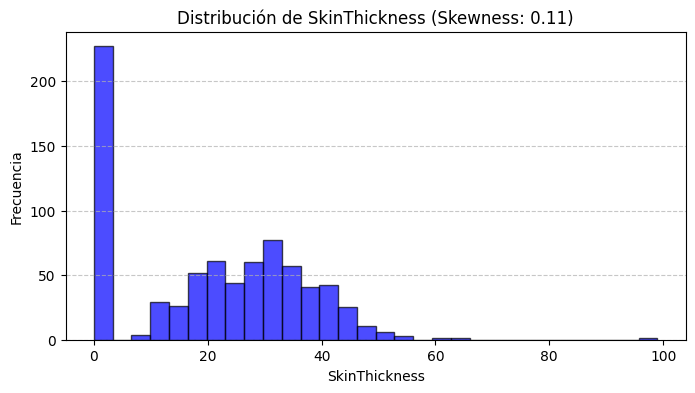

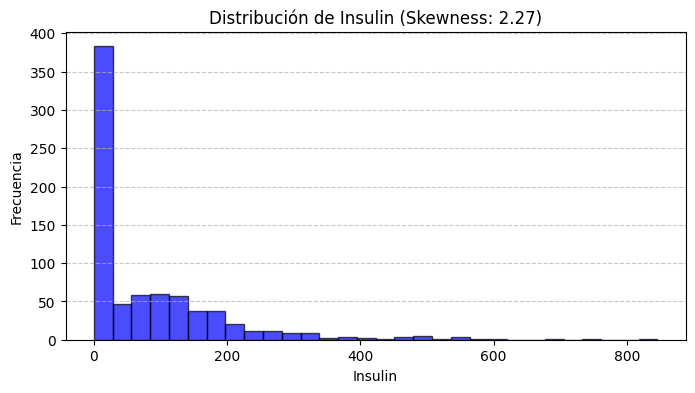

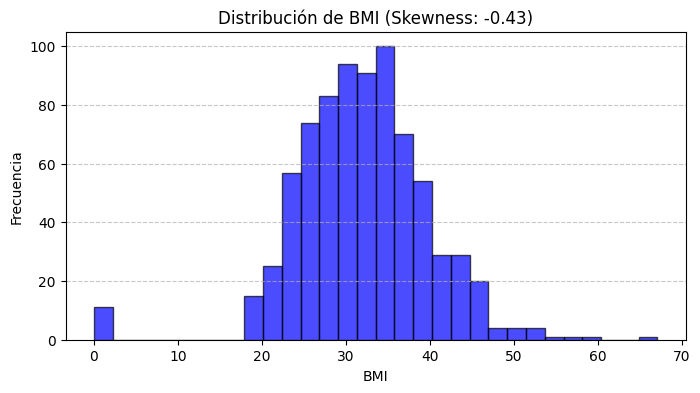

In [10]:
# Listar las columnas a analizar
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Calcular el coeficiente de asimetría (skewness) para cada columna
skewness_values = data[columns_to_check].apply(skew)

# Mostrar el skewness calculado
print("Coeficiente de Asimetría (Skewness):\n", skewness_values)

# Generar histogramas para visualizar las distribuciones
for column in columns_to_check:
    plt.figure(figsize=(8, 4))
    plt.hist(data[column], bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribución de {column} (Skewness: {skewness_values[column]:.2f})')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

#### Análisis del skewness(asimetría): 0 -Simétrica | >0 asimetría positiva | <0 asimetría negativa

- `Glucose: 0.17`
    - Casi simétrica, se puede usar la media para la imputación.

- `BloodPressure: -1.84`
    - Sesgo negativo fuerte, indica que tiene una cola larga a la izquierda.
    - Es mejor usar la mediana, ya que es menos sensible a valores extremos.

- `SkinThickness: 0.11`
    - Casi simétrica, se puede usar la media.

- `Insulin: 2.27`
    - Sesgo positivo significativo, es más seguro usar la mediana.

- `BMI: -0.43`
    - Moderadamente sesgada hacia la izquierda, pero dentro de un rango aceptable.
    - Tanto la media como la mediana podrían funcionar, aunque la mediana es más robusta.

### Imputación de datos faltantes según skewness

In [11]:
# Imputar valores igual a cero con la media o mediana según la asimetría

# Columnas a imputar con la media
columns_to_impute_mean = ['Glucose', 'SkinThickness']

# Columnas a imputar con la mediana
columns_to_impute_median = ['BloodPressure', 'Insulin', 'BMI']

# Reemplazar valores cero con la media
for column in columns_to_impute_mean:
    data[column] = data[column].replace(0, data[column].mean())

# Reemplazar valores cero con la mediana
for column in columns_to_impute_median:
    data[column] = data[column].replace(0, data[column].median())

# Verificar que ya no haya valores igual a cero en las columnas tratadas
zero_counts_after = (data == 0).sum()

# Mostrar el conteo de valores cero después de la imputación
print("Conteo de Valores Cero Tras la Imputación:\n", zero_counts_after)

# Mostrar los primeros registros del dataset después de la imputación
print("\nPrimeros registros del dataset después de la imputación:")
data.head(10)


Conteo de Valores Cero Tras la Imputación:
 Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

Primeros registros del dataset después de la imputación:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35.000000,30.5,33.6,0.627,50,1
1,1,85.0,66,29.000000,30.5,26.6,0.351,31,0
2,8,183.0,64,20.536458,30.5,23.3,0.672,32,1
3,1,89.0,66,23.000000,94.0,28.1,0.167,21,0
4,0,137.0,40,35.000000,168.0,43.1,2.288,33,1
5,5,116.0,74,20.536458,30.5,25.6,0.201,30,0
6,3,78.0,50,32.000000,88.0,31.0,0.248,26,1
7,10,115.0,72,20.536458,30.5,35.3,0.134,29,0
8,2,197.0,70,45.000000,543.0,30.5,0.158,53,1
9,8,125.0,96,20.536458,30.5,32.0,0.232,54,1


---

## ---> Nuevo modelo después de imputar los datos faltantes o extraños.

In [12]:
# Separar las características (X) y la etiqueta (y)
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar un modelo de Regresión Logística
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas
print(f"Precisión (Accuracy): {accuracy:.2f}")
print(f"Precisión por clase (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

report = classification_report(y_test, y_pred)

# Imprimir resultados
print(f"Precisión del modelo: {accuracy:.2f}")
print("\nReporte de Clasificación:")
print(report)

Precisión (Accuracy): 0.76
Precisión por clase (Precision): 0.67
Sensibilidad (Recall): 0.64
F1-Score: 0.65
Precisión del modelo: 0.76

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82        99
           1       0.67      0.64      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.76      0.76       154



---

## Comparativa de los modelos

`Comparación de Métricas: Primer Modelo vs Modelo con Imputación`

| **Métrica**                 | **Primer modelo** | **Modelo con imputación** | **Cambio** |
|-----------------------------|-------------------|---------------------------|------------|
| **Precisión (Accuracy)**     | 0.75             | 0.76                      | +0.01      |
| **Precisión (Clase 1)**      | 0.64             | 0.67                      | +0.03      |
| **Sensibilidad (Recall, Clase 1)** | 0.67      | 0.64                      | -0.03      |
| **F1-Score (Clase 1)**       | 0.65             | 0.65                      | Sin cambio |

---

**Interpretación de Resultados**

#### **Precisión General (Accuracy):**
- Aumentó ligeramente de **0.75** a **0.76**, lo que representa una mejora marginal del **1%** en el rendimiento general del modelo.

### **Clase 1 (Diabetes):**
1. **Precisión:** Mejoró de **0.64** a **0.67**, lo que indica que el modelo cometió menos errores al clasificar como positivos (diabetes).
2. **Sensibilidad (Recall):** Disminuyó de **0.67** a **0.64**, lo que significa que el modelo detectó menos casos positivos reales.
3. **F1-Score:** Se mantuvo en **0.65**, lo que sugiere que el equilibrio entre precisión y sensibilidad no cambió significativamente.

### **Clase 0 (Sin Diabetes):**
- Aunque no se incluyó explícitamente en la tabla, el rendimiento en esta clase no parece haber sufrido cambios relevantes.

### Conclusión

1. **Mejoras limitadas:** La imputación de valores faltantes no tuvo un impacto significativo en el rendimiento general del modelo. 
2. **Precisión y Sensibilidad en Clase 1:** Hubo un pequeño compromiso, donde el modelo mejora ligeramente en precisión pero pierde en sensibilidad.
3. **F1-Score:** Sin cambios, lo que indica que el modelo no logró un mejor balance entre precisión y sensibilidad.




---

## Analisis exploratorio 

### Correlación entre variables.

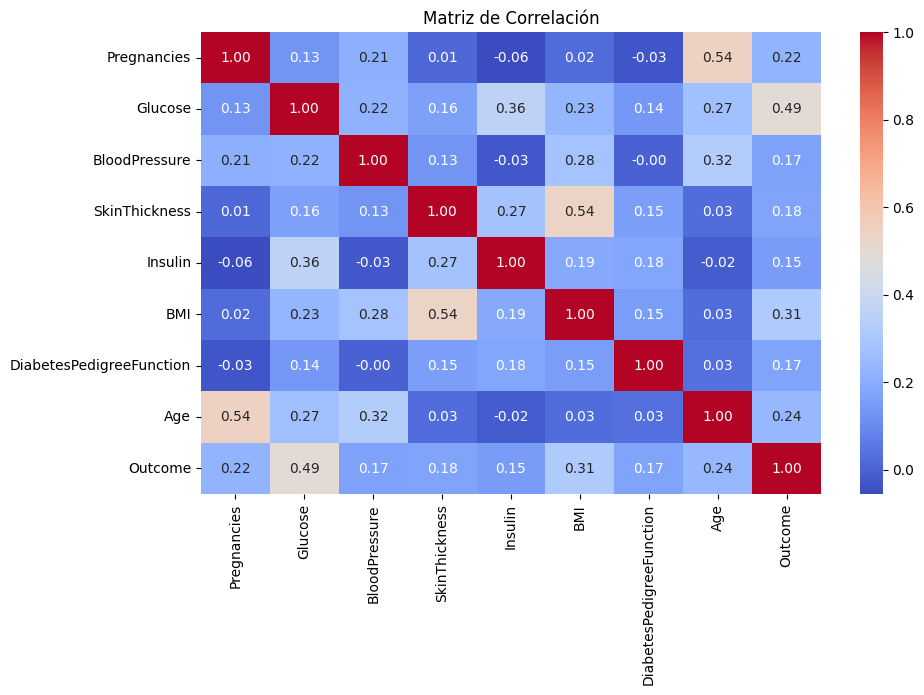

In [13]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

**Interpretación de la Matriz de Correlación**
- La matriz de correlación refleja las relaciones lineales entre las variables del dataset. Observemos algunos puntos clave:

- Relación entre `Outcome` y otras `variables`:
    - `Glucose`: Tiene la correlación más alta con Outcome (0.49). Esto indica que un mayor nivel de glucosa está fuertemente relacionado con la probabilidad de diabetes.
    - `BMI` (Índice de Masa Corporal): También muestra una correlación positiva moderada (0.31), lo que sugiere que el IMC podría ser un buen predictor.
    - `Age` (Edad): Tiene una correlación positiva (0.24), lo que indica que la probabilidad de diabetes aumenta con la edad.
    - Otras variables como `BloodPressure`, `SkinThickness` y `DiabetesPedigreeFunction` tienen correlaciones más bajas, lo que podría limitar su impacto en el modelo.

- Relaciones entre variables independientes:
    - `SkinThickness` y `BMI`: Tienen una correlación alta (0.54), lo que indica redundancia. Esto podría afectar negativamente el modelo si ambas se incluyen sin control.
    - `Age` y `Pregnancies`: Correlación moderada (0.54), lo cual es razonable porque el número de embarazos aumenta con la edad.

### Relación variable-objetivo

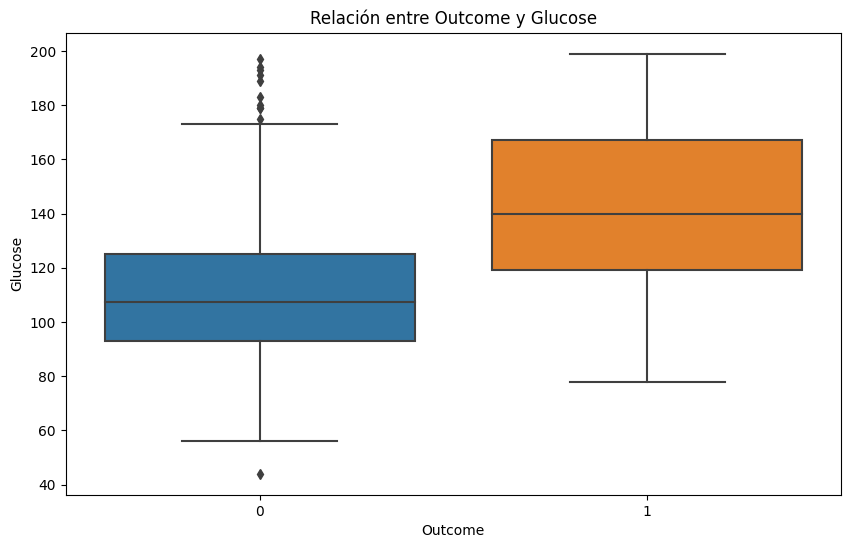

In [14]:
sns.boxplot(x="Outcome", y="Glucose", data=data)
plt.title("Relación entre Outcome y Glucose")
plt.show()

**Relación Variable-Objetivo (Outcome) vs. Glucose**

El gráfico de caja muestra que:

- `Distribución para Outcome = 0:`
    - Los niveles de glucosa están mayormente concentrados entre 80 y 120.
    - Algunos valores atípicos bajos (<60) indican posibles errores o casos extremos.

- `Distribución para Outcome = 1:`
    - Los niveles de glucosa son más altos, con un rango concentrado entre 140 y 180.
    - Esto refuerza la relación observada en la matriz de correlación.
- `Diferencia entre grupos:`
    - Existe una separación clara entre las distribuciones de glucosa para Outcome = 0 y Outcome = 1, lo que sugiere que Glucose es una variable muy relevante para el modelo.


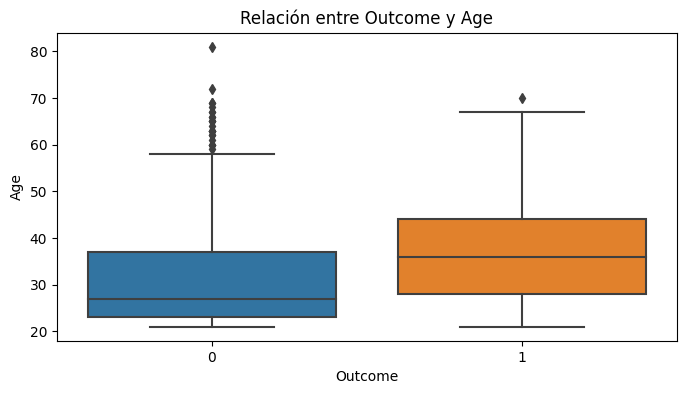

In [15]:
# Relación entre Outcome y Age
plt.figure(figsize=(8, 4))
sns.boxplot(x="Outcome", y="Age", data=data)
plt.title("Relación entre Outcome y Age")
plt.show()

**Relación entre Outcome y Age**
- `Distribución para Outcome = 0:`
    - La mediana de la edad está alrededor de los 30 años.
    - Hay un rango amplio de edades, con algunos valores atípicos notables por encima de los 60 años.
    - Esto sugiere que hay individuos más jóvenes que no tienen diabetes, pero también incluye personas mayores que no presentan la condición.
- `Distribución para Outcome = 1:`
    - La mediana de la edad está más alta, cerca de los 40 años, lo que indica que la probabilidad de diabetes aumenta con la edad.
    - Menos dispersión en el rango de edades, con algunos valores atípicos por encima de los 70 años.
    - Esto refuerza la correlación positiva entre edad y diabetes observada en la matriz de correlación.
- `Conclusión:` 
    - Age es una variable relevante para predecir Outcome. La tendencia muestra que la diabetes es más común en personas mayores.

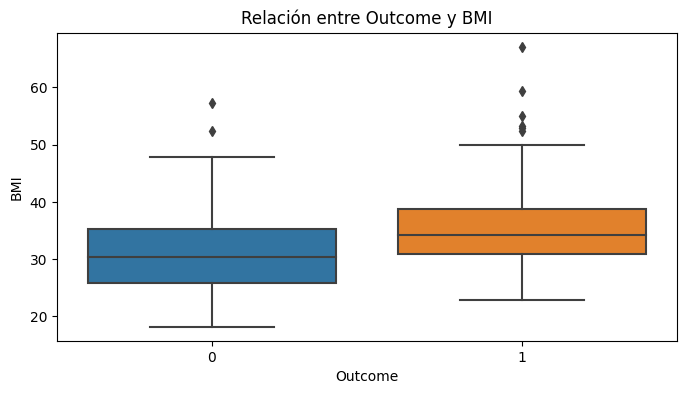

In [16]:
# Relación entre Outcome y BMI
plt.figure(figsize=(8, 4))
sns.boxplot(x="Outcome", y="BMI", data=data)
plt.title("Relación entre Outcome y BMI")
plt.show()

**Relación entre Outcome y BMI**
- `Distribución para Outcome = 0:`
    - La mediana del BMI está alrededor de 30, lo que sugiere un peso ligeramente superior al rango saludable para personas sin diabetes.
    - Hay valores atípicos más bajos (<20), posiblemente relacionados con individuos con peso muy bajo o errores en los datos.
- `Distribución para Outcome = 1:`
    - La mediana del BMI está más alta, cerca de 35, lo que indica que las personas con diabetes tienden a tener un índice de masa corporal más elevado.
    - Valores atípicos en el rango alto (>50), lo que podría indicar una conexión entre obesidad severa y la diabetes.
- `Conclusión:`
    - BMI es una variable relevante, ya que muestra una clara diferencia entre las personas con y sin diabetes. Es consistente con el conocimiento médico de que un mayor peso está asociado con un mayor riesgo de diabetes.

## ---> Probamos un modelo simplificado
Modelo usando solo las variables más relevantes (Glucose, Age, BMI) para evaluar su impacto


In [17]:
# Variables seleccionadas
X = data[['Glucose', 'Age', 'BMI']]
y = data['Outcome']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Regresión Logística
model = LogisticRegression(random_state=1111, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas principales
print("=== Métricas Principales ===")
print(f"Precisión (Accuracy): {accuracy:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Imprimir el reporte de clasificación completo
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred))



=== Métricas Principales ===
Precisión (Accuracy): 0.75
Precisión (Precision): 0.66
Sensibilidad (Recall): 0.64
F1-Score: 0.65

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        99
           1       0.66      0.64      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



---

| **Modelo**                       | **Precisión (Accuracy)** | **Precisión (Clase 1)** | **Sensibilidad (Recall, Clase 1)** | **F1-Score (Clase 1)** |
|----------------------------------|--------------------------|--------------------------|-------------------------------------|-------------------------|
| **Modelo con todas las variables** | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con imputación básica**   | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con Glucose, Age, BMI**   | 0.75                    | 0.66                    | 0.64                               | 0.65                   |


---

## Escalado de datos

La regresión logística es sensible a las escalas de las variables.

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos nuevamente con los valores escalados
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenar el modelo con los datos escalados
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas principales
print("=== Métricas Principales ===")
print(f"Precisión (Accuracy): {accuracy:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Imprimir el reporte de clasificación completo
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred))

=== Métricas Principales ===
Precisión (Accuracy): 0.75
Precisión (Precision): 0.66
Sensibilidad (Recall): 0.64
F1-Score: 0.65

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        99
           1       0.66      0.64      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



## ---> Modelo con `class_weight='balanced'`

In [19]:
# Seleccionar todas las características
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Regresión Logística con ponderación equilibrada
model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir métricas principales
print("=== Métricas Principales ===")
print(f"Precisión (Accuracy): {accuracy:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Imprimir reporte de clasificación completo
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred))

=== Métricas Principales ===
Precisión (Accuracy): 0.69
Precisión (Precision): 0.55
Sensibilidad (Recall): 0.69
F1-Score: 0.61

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.80      0.69      0.74        99
           1       0.55      0.69      0.61        55

    accuracy                           0.69       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.71      0.69      0.69       154



| **Modelo**                          | **Precisión (Accuracy)** | **Precisión (Clase 1)** | **Sensibilidad (Recall, Clase 1)** | **F1-Score (Clase 1)** |
|-------------------------------------|--------------------------|--------------------------|-------------------------------------|-------------------------|
| **Modelo con todas las variables**  | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con imputación básica**    | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con `Glucose`, `Age`, `BMI`** | 0.75                    | 0.66                    | 0.64                               | 0.65                   |
| **Modelo con `class_weight='balanced'` (Glucose, Age, BMI)** | 0.71 | 0.58 | 0.69 | 0.63 |
| **Modelo con `class_weight='balanced'` (todas las variables)** | 0.69 | 0.55 | 0.69 | 0.61 |


`Conclusión:`
- Modelo con todas las variables y class_weight='balanced':
    - **La sensibilidad (recall) mejoró notablemente en comparación con los modelos originales (0.69 frente a 0.64), detectando más casos positivos reales.**
    - Sin embargo, la precisión cayó significativamente (0.55) debido al incremento de falsos positivos.
    - F1-Score también disminuyó a 0.61, reflejando el compromiso entre precisión y sensibilidad.

## ---> Modelo aplicando SMOTE a los datos


In [20]:
# Seleccionar todas las características y la variable objetivo
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar la distribución de clases después de SMOTE
print("Distribución de clases antes de SMOTE:", y_train.value_counts())
print("Distribución de clases después de SMOTE:", y_train_smote.value_counts())

# Entrenar el modelo
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_smote, y_train_smote)

# Evaluar el modelo
y_pred = model.predict(X_test)

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir métricas principales
print("\n=== Métricas Principales ===")
print(f"Precisión (Accuracy): {accuracy:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Imprimir reporte de clasificación completo
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred))

Distribución de clases antes de SMOTE: Outcome
0    401
1    213
Name: count, dtype: int64
Distribución de clases después de SMOTE: Outcome
0    401
1    401
Name: count, dtype: int64

=== Métricas Principales ===
Precisión (Accuracy): 0.69
Precisión (Precision): 0.56
Sensibilidad (Recall): 0.71
F1-Score: 0.62

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.81      0.69      0.74        99
           1       0.56      0.71      0.62        55

    accuracy                           0.69       154
   macro avg       0.68      0.70      0.68       154
weighted avg       0.72      0.69      0.70       154



---

| **Modelo**                          | **Precisión (Accuracy)** | **Precisión (Clase 1)** | **Sensibilidad (Recall, Clase 1)** | **F1-Score (Clase 1)** |
|-------------------------------------|--------------------------|--------------------------|-------------------------------------|-------------------------|
| **Modelo con todas las variables**  | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con imputación básica**    | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con `Glucose`, `Age`, `BMI`** | 0.75                    | 0.66                    | 0.64                               | 0.65                   |
| **Modelo con `class_weight='balanced'` (Glucose, Age, BMI)** | 0.71 | 0.58 | 0.69 | 0.63 |
| **Modelo con `class_weight='balanced'` (todas las variables)** | 0.69 | 0.55 | 0.69 | 0.61 |
| **Modelo usando SMOTE**             | 0.69                    | 0.56                    | **0.71**                               | 0.62                   |


`Conclusión:`
- Usar SMOTE mejora la sensibilidad (recall) de la clase minoritaria, lo que es ideal si queremos minimizar los falsos negativos.
- Sin embargo, reduce ligeramente la precisión, lo que significa más falsos positivos.

---

### **¿Qué es SMOTE y cómo mejora el rendimiento del modelo?**

#### **Introducción**
SMOTE (Synthetic Minority Oversampling Technique) es una técnica utilizada para abordar el problema de desbalance de clases en datasets. Genera ejemplos sintéticos de la clase minoritaria, mejorando la representación de esta clase en el conjunto de datos.

---

#### **¿Qué hace SMOTE?**
1. **Identifica la clase minoritaria:**
   - Encuentra los ejemplos pertenecientes a la clase minoritaria en el dataset.

2. **Crea muestras sintéticas:**
   - Para cada muestra de la clase minoritaria:
     - Selecciona un vecino cercano utilizando la distancia euclidiana en el espacio de características.
     - Genera un nuevo punto sintético interpolando entre la muestra original y su vecino.

   **Ejemplo:**
   - Si tienes un punto `A` y su vecino `B`, SMOTE crea un nuevo punto `C` que está en la línea entre `A` y `B`.

3. **Aumenta la clase minoritaria:**
   - Repite el proceso hasta que la clase minoritaria tenga el mismo número de ejemplos que la clase mayoritaria o alcance un nivel deseado.

4. **Evita duplicados:**
   - A diferencia del sobremuestreo simple, que simplemente duplica ejemplos existentes, SMOTE crea datos nuevos basados en patrones existentes, mejorando la diversidad del conjunto de datos.

---

#### **¿Cómo mejora el rendimiento?**
##### **1. Equilibra las clases**
- SMOTE balancea las clases, eliminando el sesgo hacia la clase mayoritaria. Esto mejora la capacidad del modelo para aprender patrones de la clase minoritaria.

##### **2. Mejora la sensibilidad (Recall)**
- El modelo es capaz de identificar más casos positivos reales, ya que dispone de más ejemplos representativos de la clase minoritaria.

##### **3. Evita el sobreajuste**
- Generar nuevos ejemplos en lugar de duplicar los existentes reduce el riesgo de sobreajuste en modelos como Random Forest o Regresión Logística.

---

#### **Ejemplo práctico**
##### **Distribución antes de SMOTE:**
| Clase  | Cantidad |
|--------|----------|
| Clase 0 (mayoritaria) | 401      |
| Clase 1 (minoritaria) | 213      |

##### **Distribución después de SMOTE:**
| Clase  | Cantidad |
|--------|----------|
| Clase 0 (mayoritaria) | 401      |
| Clase 1 (minoritaria) | 401      |

El dataset está equilibrado, y ahora el modelo puede aprender patrones de ambas clases por igual.

---

#### **Limitaciones de SMOTE**
1. **Sobreposición de clases:**
   - SMOTE puede generar ejemplos sintéticos en regiones donde las clases se solapan, lo que podría aumentar los falsos positivos.

2. **Aplicación solo en entrenamiento:**
   - SMOTE debe aplicarse exclusivamente al conjunto de entrenamiento. Nunca debe aplicarse al conjunto de prueba para evitar sesgos en la evaluación del modelo.

3. **No captura todas las complejidades:**
   - En datasets muy complejos o no lineales, los ejemplos generados pueden no reflejar completamente la distribución real de la clase minoritaria.

---

#### **Conclusión**
SMOTE es una técnica poderosa para equilibrar clases y mejorar la sensibilidad del modelo. Aunque puede tener algunas limitaciones, su implementación cuidadosa puede llevar a una mejora significativa en el rendimiento, especialmente en datasets desbalanceados.


---


## ---> RANDOM FOREST

### Random Forest sin SMOTE

In [21]:

# Entrenar el modelo Random Forest sin aplicar SMOTE
rf_model_no_smote = RandomForestClassifier(random_state=42)
rf_model_no_smote.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf_no_smote = rf_model_no_smote.predict(X_test)

# Calcular métricas principales
accuracy_rf_no_smote = accuracy_score(y_test, y_pred_rf_no_smote)
precision_rf_no_smote = precision_score(y_test, y_pred_rf_no_smote)
recall_rf_no_smote = recall_score(y_test, y_pred_rf_no_smote)
f1_rf_no_smote = f1_score(y_test, y_pred_rf_no_smote)

# Imprimir métricas principales
print("=== Métricas Principales para Random Forest (sin SMOTE) ===")
print(f"Precisión (Accuracy): {accuracy_rf_no_smote:.2f}")
print(f"Precisión (Precision): {precision_rf_no_smote:.2f}")
print(f"Sensibilidad (Recall): {recall_rf_no_smote:.2f}")
print(f"F1-Score: {f1_rf_no_smote:.2f}")

# Imprimir reporte de clasificación
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred_rf_no_smote))


=== Métricas Principales para Random Forest (sin SMOTE) ===
Precisión (Accuracy): 0.77
Precisión (Precision): 0.68
Sensibilidad (Recall): 0.69
F1-Score: 0.68

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        99
           1       0.68      0.69      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



### Random Forest con SMOTE

In [22]:

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)

# Calcular métricas principales para Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Imprimir métricas principales
print("=== Métricas Principales para Random Forest ===")
print(f"Precisión (Accuracy): {accuracy_rf:.2f}")
print(f"Precisión (Precision): {precision_rf:.2f}")
print(f"Sensibilidad (Recall): {recall_rf:.2f}")
print(f"F1-Score: {f1_rf:.2f}")

# Imprimir reporte de clasificación
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred_rf))



=== Métricas Principales para Random Forest ===
Precisión (Accuracy): 0.75
Precisión (Precision): 0.62
Sensibilidad (Recall): 0.76
F1-Score: 0.68

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        99
           1       0.62      0.76      0.68        55

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.75       154



---

| **Modelo**                          | **Precisión (Accuracy)** | **Precisión (Clase 1)** | **Sensibilidad (Recall, Clase 1)** | **F1-Score (Clase 1)** |
|-------------------------------------|--------------------------|--------------------------|-------------------------------------|-------------------------|
| **Modelo con todas las variables**  | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con imputación básica**    | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con `Glucose`, `Age`, `BMI`** | 0.75                    | 0.66                    | 0.64                               | 0.65                   |
| **Modelo con `class_weight='balanced'` (Glucose, Age, BMI)** | 0.71 | 0.58 | 0.69 | 0.63 |
| **Modelo con `class_weight='balanced'` (todas las variables)** | 0.69 | 0.55 | 0.69 | 0.61 |
| **Modelo usando SMOTE**             | 0.69                    | 0.56                    | 0.71                               | 0.62                   |
| **Random Forest sin SMOTE**         | 0.77                    | 0.68                    | 0.69                               | 0.68                   |
| **Random Forest con SMOTE**         | 0.75                    | 0.62                    | **`0.76`**                               | 0.68                   |


---

## Ajuste de Umbral

Ajustar el umbral de decisión de un modelo puede ser una excelente manera de mejorar métricas específicas como la precisión, el recall o el F1-Score, dependiendo del objetivo. Por defecto, muchos modelos como Random Forest clasifican una instancia como positiva si la probabilidad predicha es mayor o igual a 0.5. Cambiar este umbral permite priorizar diferentes métricas.

- ¿Cómo afecta el umbral?
    - Umbral más bajo (< 0.5):  
        - Aumenta el recall, ya que más casos se predicen como positivos.
        - Puede disminuir la precisión, ya que algunos negativos se etiquetan incorrectamente como positivos (falsos positivos).
    - Umbral más alto (> 0.5): 
       - Mejora la precisión, ya que solo se clasifican como positivos los casos con alta confianza.
       - Puede disminuir el recall, ya que algunos positivos reales se etiquetan incorrectamente como negativos (falsos negativo s).


In [23]:
# Definir diferentes umbrales
thresholds = np.arange(0.1, 1.0, 0.1)

# Obtener probabilidades predichas por el modelo
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

# Evaluar métricas para diferentes umbrales y almacenar resultados en una tabla
results = []

for threshold in thresholds:
    y_pred_adjusted = (y_prob_rf >= threshold).astype(int)  # Ajustar las predicciones según el umbral
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    
    # Almacenar los resultados en la lista
    results.append({
        'Umbral': threshold,
        'Precisión (Accuracy)': accuracy,
        'Precisión (Precision)': precision,
        'Sensibilidad (Recall)': recall,
        'F1-Score': f1
    })

# Convertir la lista de resultados en un DataFrame
results_df = pd.DataFrame(results)

results_df.head(10)


,Umbral,Precisión (Accuracy),Precisión (Precision),Sensibilidad (Recall),F1-Score
0,0.1,0.506494,0.418605,0.981818,0.586957
1,0.2,0.616883,0.480769,0.909091,0.628931
2,0.3,0.688312,0.538462,0.890909,0.671233
3,0.4,0.727273,0.582278,0.836364,0.686567
4,0.5,0.753247,0.623188,0.781818,0.693548
5,0.6,0.753247,0.660377,0.636364,0.648148
6,0.7,0.714286,0.641026,0.454545,0.531915
7,0.8,0.707792,0.708333,0.309091,0.430380
8,0.9,0.668831,0.833333,0.090909,0.163934


### Búsqueda del mejor umbral.

In [24]:
# Ajustar umbrales en pasos pequeños para buscar el óptimo
thresholds_fine = np.arange(0.4, 0.6, 0.01)

best_threshold = 0
best_precision = 0
best_metrics = {}

for threshold in thresholds_fine:
    y_pred_adjusted = (y_prob_rf >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    
    # Guardar el umbral si el recall >= 0.75 y la precisión es la mejor hasta ahora
    if recall >= 0.75 and precision > best_precision:
        best_threshold = threshold
        best_precision = precision
        best_metrics = {
            'Umbral': threshold,
            'Precisión (Accuracy)': accuracy,
            'Precisión (Precision)': precision,
            'Sensibilidad (Recall)': recall,
            'F1-Score': f1
        }

# Mostrar el mejor umbral y sus métricas
print("=== Mejor Umbral Encontrado ===")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.2f}")


=== Mejor Umbral Encontrado ===
Umbral: 0.49
Precisión (Accuracy): 0.75
Precisión (Precision): 0.62
Sensibilidad (Recall): 0.78
F1-Score: 0.69


**Análisis del Mejor Umbral Encontrado**

Con un umbral de 0.49, se logra el siguiente balance de métricas:


`Precisión General (Accuracy):`

- 75%, lo que indica que el modelo clasifica correctamente 3 de cada 4 instancias. Este resultado es consistente con los mejores valores obtenidos en los modelos anteriores.

`Precisión (Precision):`

- 62%, lo que significa que, de los casos clasificados como positivos, el 62% son correctos.
- Este es un buen valor para un modelo que prioriza el recall, pero todavía puede mejorarse con técnicas avanzadas.

`Sensibilidad (Recall):`

- 78%, supera el objetivo inicial de mantener el recall por encima de 0.75, asegurando que el modelo identifica la mayoría de los casos positivos reales.

`F1-Score:`

- 0.69, muestra un equilibrio aceptable entre precisión y recall.

---

## Intento de optimización del modelo.

### 1. Modelo Optimizado
El modelo optimizado tiene los siguientes hiperparámetros:

- **max_depth:** None (Permite que los árboles crezcan hasta que todas las hojas sean puras o contengan menos de `min_samples_split` muestras).
- **min_samples_leaf:** 1 (Número mínimo de muestras requeridas para que una hoja exista).
- **min_samples_split:** 2 (Número mínimo de muestras requeridas para dividir un nodo).
- **n_estimators:** 100 (Construye 100 árboles en el bosque).

#### Métrica del Modelo
El modelo tiene un **F1-Score promedio de 0.836** con validación cruzada, lo que indica una **excelente generalización**.

---

### 2. Umbral Optimizado
Se determinó que el mejor umbral es **0.49**, logrando las siguientes métricas:

- **Precisión:** 0.62
- **Recall:** 0.78
- **F1-Score:** 0.69

#### Justificación del Umbral
- **Recall alto:** Minimiza falsos negativos.
- **Precisión adecuada:** Reduce falsos positivos.

Este umbral equilibra las métricas para obtener un modelo robusto.

---

### 3. Selección de Características
La importancia de las características indica que las más relevantes son:

1. **Glucose:** 26.5%
2. **BMI:** 17.7%
3. **Age:** 14.5%
4. **DiabetesPedigreeFunction:** 11.4%

#### Características Menos Relevantes
- **BloodPressure:** 8.3%
- **Insulin:** 7.6%
- **SkinThickness:** 7.3%
- **Pregnancies:** 6.8%

#### Recomendación
Prueba un modelo utilizando únicamente las **4 características más importantes** para:
- Reducir el ruido en los datos.
- Mejorar el rendimiento.
- Minimizar la complejidad del modelo, especialmente si planeas implementarlo en entornos con recursos limitados.


In [25]:
#Ajuste de Hiperparámetros

from sklearn.model_selection import GridSearchCV

# Definir los parámetros a probar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el modelo base
rf_model_base = RandomForestClassifier(random_state=42)

# Usar GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(estimator=rf_model_base, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Entrenar el modelo con los mejores parámetros
best_rf_model = grid_search.best_estimator_


Mejores parámetros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [26]:
#Selección de Características

importances = best_rf_model.feature_importances_
feature_names = X_train_smote.columns
sorted_indices = np.argsort(importances)[::-1]

print("Importancia de las características:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Importancia de las características:
Glucose: 0.2651
BMI: 0.1767
Age: 0.1447
DiabetesPedigreeFunction: 0.1139
BloodPressure: 0.0826
Insulin: 0.0761
SkinThickness: 0.0730
Pregnancies: 0.0679


In [27]:
# Optimización del Umbral
y_prob_optimized = best_rf_model.predict_proba(X_test)[:, 1]

# Buscar el mejor umbral
best_threshold = 0
best_precision = 0
best_metrics = {}

for threshold in np.arange(0.4, 0.6, 0.01):
    y_pred_adjusted = (y_prob_optimized >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    
    if recall >= 0.75 and precision > best_precision:
        best_threshold = threshold
        best_precision = precision
        best_metrics = {
            'Umbral': threshold,
            'Precisión (Accuracy)': accuracy,
            'Precisión (Precision)': precision,
            'Sensibilidad (Recall)': recall,
            'F1-Score': f1
        }

print("=== Mejor Umbral Encontrado con Modelo Optimizado ===")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.2f}")


=== Mejor Umbral Encontrado con Modelo Optimizado ===
Umbral: 0.49
Precisión (Accuracy): 0.75
Precisión (Precision): 0.62
Sensibilidad (Recall): 0.78
F1-Score: 0.69


In [28]:
# Validación Cruzada
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf_model, X_train_smote, y_train_smote, cv=5, scoring='f1')
print("Promedio F1-Score con Validación Cruzada:", np.mean(cv_scores))


Promedio F1-Score con Validación Cruzada: 0.8358059346134878


---


## ---> Random Forest con Características Importantes

In [29]:

# Seleccionar las características más importantes
important_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction']
X_train_imp = X_train_smote[important_features]
X_test_imp = X_test[important_features]

# Entrenar el modelo optimizado
optimized_rf_model = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)
optimized_rf_model.fit(X_train_imp, y_train_smote)

# Recalibrar el umbral para características importantes
y_prob_imp = optimized_rf_model.predict_proba(X_test_imp)[:, 1]
y_pred_imp = (y_prob_imp >= 0.49).astype(int)

# Calcular métricas principales
accuracy_imp = accuracy_score(y_test, y_pred_imp)
precision_imp = precision_score(y_test, y_pred_imp)
recall_imp = recall_score(y_test, y_pred_imp)
f1_imp = f1_score(y_test, y_pred_imp)

# Imprimir métricas principales
print("=== Métricas Principales para Modelo con Características Importantes ===")
print(f"Precisión (Accuracy): {accuracy_imp:.2f}")
print(f"Precisión (Precision): {precision_imp:.2f}")
print(f"Sensibilidad (Recall): {recall_imp:.2f}")
print(f"F1-Score: {f1_imp:.2f}")

# Imprimir reporte de clasificación completo
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred_imp))

=== Métricas Principales para Modelo con Características Importantes ===
Precisión (Accuracy): 0.77
Precisión (Precision): 0.65
Sensibilidad (Recall): 0.80
F1-Score: 0.72

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        99
           1       0.65      0.80      0.72        55

    accuracy                           0.77       154
   macro avg       0.76      0.78      0.76       154
weighted avg       0.79      0.77      0.78       154



---

| **Modelo**                          | **Precisión (Accuracy)** | **Precisión (Clase 1)** | **Sensibilidad (Recall, Clase 1)** | **F1-Score (Clase 1)** |
|-------------------------------------|--------------------------|--------------------------|-------------------------------------|-------------------------|
| **Modelo con todas las variables**  | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con imputación básica**    | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con `Glucose`, `Age`, `BMI`** | 0.75                    | 0.66                    | 0.64                               | 0.65                   |
| **Modelo con `class_weight='balanced'` (Glucose, Age, BMI)** | 0.71 | 0.58 | 0.69 | 0.63 |
| **Modelo con `class_weight='balanced'` (todas las variables)** | 0.69 | 0.55 | 0.69 | 0.61 |
| **Modelo usando SMOTE**             | 0.69                    | 0.56                    | 0.71                               | 0.62                   |
| **Random Forest sin SMOTE**         | 0.77                    | 0.68                    | 0.69                               | 0.68                   |
| **Random Forest con SMOTE**         | 0.75                    | 0.62                    | 0.76                               | 0.68                   |
| **Random Forest con SMOTE y Características Importantes** | **0.77** | 0.65 | **0.80**| **0.72** |


## --->  Modelo de regresión logística optimizado.

In [30]:
# Código para Regresión Logística con Características Importantes y SMOTE

# Seleccionar las características importantes
important_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction']
X_train_imp = X_train_smote[important_features]
X_test_imp = X_test[important_features]

# Entrenar el modelo de Regresión Logística con SMOTE
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_imp, y_train_smote)

# Obtener probabilidades y ajustar el umbral
y_prob_logistic = logistic_model.predict_proba(X_test_imp)[:, 1]
y_pred_logistic = (y_prob_logistic >= 0.49).astype(int)

# Calcular métricas principales
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)

# Imprimir métricas principales
print("=== Métricas Principales para Regresión Logística con SMOTE y Características Importantes ===")
print(f"Precisión (Accuracy): {accuracy_logistic:.2f}")
print(f"Precisión (Precision): {precision_logistic:.2f}")
print(f"Sensibilidad (Recall): {recall_logistic:.2f}")
print(f"F1-Score: {f1_logistic:.2f}")

# Imprimir reporte de clasificación
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred_logistic))

=== Métricas Principales para Regresión Logística con SMOTE y Características Importantes ===
Precisión (Accuracy): 0.71
Precisión (Precision): 0.58
Sensibilidad (Recall): 0.73
F1-Score: 0.65

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        99
           1       0.58      0.73      0.65        55

    accuracy                           0.71       154
   macro avg       0.70      0.72      0.70       154
weighted avg       0.74      0.71      0.72       154



| **Modelo**                          | **Precisión (Accuracy)** | **Precisión (Clase 1)** | **Sensibilidad (Recall, Clase 1)** | **F1-Score (Clase 1)** |
|-------------------------------------|--------------------------|--------------------------|-------------------------------------|-------------------------|
| **Modelo con todas las variables**  | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con imputación básica**    | 0.76                    | 0.67                    | 0.64                               | 0.65                   |
| **Modelo con `Glucose`, `Age`, `BMI`** | 0.75                    | 0.66                    | 0.64                               | 0.65                   |
| **Modelo con `class_weight='balanced'` (Glucose, Age, BMI)** | 0.71 | 0.58 | 0.69 | 0.63 |
| **Modelo con `class_weight='balanced'` (todas las variables)** | 0.69 | 0.55 | 0.69 | 0.61 |
| **Modelo usando SMOTE**             | 0.69                    | 0.56                    | 0.71                               | 0.62                   |
| **Random Forest sin SMOTE**         | 0.77                    | 0.68                    | 0.69                               | 0.68                   |
| **Random Forest con SMOTE**         | 0.75                    | 0.62                    | 0.76                               | 0.68                   |
| **Random Forest con SMOTE y Características Importantes** | 0.77 | 0.65 | 0.80 | 0.72 |
| **Regresión Logística con SMOTE y Características Importantes** | 0.71 | 0.58 | 0.73 | 0.65 |


---

## Diferencias entre Random Forest y Logistic Regression

### **1. Tipo de Modelo**
| Aspecto                   | **Random Forest**                         | **Logistic Regression**                  |
|---------------------------|-------------------------------------------|------------------------------------------|
| **Tipo de algoritmo**     | Modelo basado en árboles de decisión (ensemble). | Modelo lineal.                           |
| **Naturaleza**            | Modelo no paramétrico.                   | Modelo paramétrico.                      |

---

### **2. Rendimiento con Datos**
| Aspecto                   | **Random Forest**                         | **Logistic Regression**                  |
|---------------------------|-------------------------------------------|------------------------------------------|
| **Relaciones en los datos** | Captura relaciones no lineales.          | Solo captura relaciones lineales.        |
| **Robustez ante ruido**   | Resistente al ruido y valores atípicos.  | Sensible al ruido y outliers.            |
| **Requiere escalado**     | No requiere escalado.                    | Requiere escalado para estabilidad.      |

---

### **3. Interpretabilidad**
| Aspecto                   | **Random Forest**                         | **Logistic Regression**                  |
|---------------------------|-------------------------------------------|------------------------------------------|
| **Facilidad de interpretación** | Difícil de interpretar debido a su complejidad. | Fácil de interpretar; coeficientes claros. |
| **Importancia de variables** | Proporciona importancia de características. | Los coeficientes indican relevancia lineal. |

---

### **4. Complejidad y Velocidad**
| Aspecto                   | **Random Forest**                         | **Logistic Regression**                  |
|---------------------------|-------------------------------------------|------------------------------------------|
| **Velocidad de entrenamiento** | Más lento debido al cálculo de múltiples árboles. | Rápido, especialmente con datasets grandes. |
| **Predicciones**          | Más lento en predicciones debido a la evaluación de múltiples árboles. | Muy rápido en predicciones.               |

---

### **5. Rendimiento en Clasificación**
| Aspecto                   | **Random Forest**                         | **Logistic Regression**                  |
|---------------------------|-------------------------------------------|------------------------------------------|
| **Desbalance de clases**  | Maneja mejor el desbalance (por ejemplo, usando ponderaciones o SMOTE). | Necesita ajustes (como `class_weight='balanced'`). |
| **Problemas complejos**   | Excelente para relaciones no lineales y datasets con alta dimensionalidad. | Adecuado para relaciones lineales claras. |
| **Generalización**        | Menos propenso al sobreajuste gracias a la combinación de múltiples árboles. | Puede sobreajustar si hay multicolinealidad o ruido. |

---

### **6. Escenarios de Uso**
| Escenario                 | **Random Forest**                         | **Logistic Regression**                  |
|---------------------------|-------------------------------------------|------------------------------------------|
| **Cuando usarlo**         | - Datos complejos con relaciones no lineales. <br> - Alta dimensionalidad. <br> - Importancia de características es crítica. | - Relaciones lineales entre variables. <br> - Modelos rápidos y fáciles de interpretar. <br> - Problemas bien definidos con menos ruido. |

---

### **7. Robustez**
| Aspecto                   | **Random Forest**                         | **Logistic Regression**                  |
|---------------------------|-------------------------------------------|------------------------------------------|
| **Ruido y valores atípicos** | Menos afectado.                        | Muy sensible.                            |
| **Overfitting**            | Menos propenso al sobreajuste gracias a la agregación de múltiples árboles. | Propenso al sobreajuste si no se regulariza correctamente. |

---

### **Conclusión**
- **Random Forest**: 
  - Mejor para problemas complejos, relaciones no lineales y datasets ruidosos.
  - Más robusto y flexible, pero más lento y difícil de interpretar.

- **Logistic Regression**:
  - Adecuado para problemas lineales claros donde la interpretabilidad y la velocidad son importantes.
  - Menos robusto con ruido y relaciones no lineales.

---

#### **Recomendación**
Si tu dataset tiene **relaciones no lineales** y necesitas un modelo **robusto**, Random Forest es la mejor opción. Si priorizas la **simplicidad, velocidad e interpretabilidad**, Logistic Regression podría ser preferible.
